In [59]:
import pandas as pd
from multiprocessing import Pool
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from kpal.klib import Profile
from Bio.Seq import Seq
from Bio import SeqIO
import sklearn.cluster
from sklearn.decomposition import PCA
import sklearn.manifold
import 

In [2]:
cell_type = 'K562'
experiment = 'GSM4041593_K562_rep1.hg38'
k = 4

In [3]:
cont_data_path = f'/home/pitikovegor/CourseWork/genomes/reds_experiments/{cell_type}/parsed_contacts_{experiment}'
sequence_path = '/home/pitikovegor/CourseWork/genomes/chr_sequence'


chr_names=['chrX', 'chrY']
for i in range(1, 23):
    chr_names.append('chr%d' % (i))

In [4]:
#extract k-mers
def seq_cutter(sequence, position, chain):
    if chain=='+':
        return sequence[max(0, position[0]+1-1000) : min(position[1]+1+1000, len(sequence))]
    else:
        return sequence[max(0, position[0]+1-1000) : min(position[1]+1+1000, len(sequence))].reverse_complement()

def open_fasta (name):
    for record in SeqIO.parse(name, "fasta"): # It's a FUCKING GENERATOR!!!!!!! I need in 1st - all of the rest is alternatively
        chr_seq = record.seq
        del record
        return chr_seq
    
def k_mer_counter (k, sequence):
    k_mers_count = max(len(sequence) - k + 1, 1)
    sequence = [sequence]
    k_mers = Profile.from_sequences(sequence, k).counts
    k_mers = np.multiply(k_mers, np.array([1/k_mers_count]*len(k_mers)))
    return k_mers


def sequence_process_rna (fasta_seq, k, input_table):
    chr_seq = open_fasta(fasta_seq)
    input_table = input_table.to_numpy()
    all_kmers = []
    for cont in input_table:
        seq = seq_cutter(chr_seq, (cont[1], cont[2]), cont[3])
        seq = str(seq)
        k_mer_num = list(k_mer_counter(k, seq))
        all_kmers.append(k_mer_num)
    if all_kmers:
        all_kmers = np.array(all_kmers)
        input_table = np.concatenate((input_table, all_kmers), axis=1)
        input_table = input_table[~np.all(input_table[:, 5:] == 0, axis=1)]
        return pd.DataFrame(input_table)
    else:
        return pd.DataFrame(columns = list(range(4+4**k)))
            

In [5]:
def make_sets (contact_data_table, redc_table):
    contacts = pd.read_csv(contact_data_table, sep='\t')
    contacts = contacts.astype({"pval": float, 'contacts_count': int, 'rnaseq_count': int, 'zscore': float})
    redc = pd.read_csv(redc_table, sep='\t')
    contacts = pd.merge(left=contacts, right=redc[['id', 'is_translate', 'rna_chr', 'rna_bgn', 'rna_end', 'dna_bgn', 'dna_end', 'dna_chr', 'rna_strand', 'dna_strand']], left_on='id', right_on='id', how ='inner').drop_duplicates()
    del redc
    contacts = contacts[contacts['is_translate']==0].reset_index()
    return contacts

In [6]:
def all_tables(chr_seq, contact_data_table, redc_table, k):
    chr_cont = make_sets(contact_data_table,  redc_table)
    chr_cont = chr_cont[chr_cont['dna_chr']!=chr_cont['rna_chr']]
    kmers = sequence_process_rna(chr_seq, k, chr_cont[['id', 'rna_bgn', 'rna_end', 'rna_strand']])
    return chr_cont, kmers

In [7]:
all_proc = Pool(processes = 24)
all_data = all_proc.starmap(all_tables, [('%s/%s.fna' % (sequence_path, i), '%s/%s_full_%s.pvalue.tab.gene.txt' % (cont_data_path, i, cell_type), '%s/%s_%s.tsv' % (cont_data_path, i, experiment), k) for i in chr_names])
all_proc.close()
all_proc.join()

In [8]:
all_contacts = pd.concat([i[0] for i in all_data], ignore_index = True)
all_kmers = pd.concat([i[1] for i in all_data], ignore_index = True)

In [9]:
del all_data

In [10]:
all_contacts 

,index,Unnamed: 0,chr,id,gene,gene_ac,contacts_count,rnaseq_count,zscore,pval,gene_type,is_translate,rna_chr,rna_bgn,rna_end,dna_bgn,dna_end,dna_chr,rna_strand,dna_strand
0,0,0,chrX,M01460:89:000000000-AJJ2J:1:1101:18527:12404,ABCB7,ENSG00000131269.19,3913,2297,0.342511,0.731966,protein_coding,0,chrX,75064917,75064987,39384409,39384433,chr7,-,-
1,1,1,chrX,M01460:89:000000000-AJJ2J:1:1101:27924:7073,ABCB7,ENSG00000131269.19,3913,2297,0.342511,0.731966,protein_coding,0,chrX,75078654,75078701,143676139,143676162,chr5,-,-
2,2,2,chrX,M01460:89:000000000-AJJ2J:1:1102:11189:24626,ABCB7,ENSG00000131269.19,3913,2297,0.342511,0.731966,protein_coding,0,chrX,75073637,75073677,141088861,141088884,chr6,-,-
3,3,3,chrX,M01460:89:000000000-AJJ2J:1:1102:11949:19953,ABCB7,ENSG00000131269.19,3913,2297,0.342511,0.731966,protein_coding,0,chrX,75080808,75080852,76451580,76451604,chr17,-,-
4,4,4,chrX,M01460:89:000000000-AJJ2J:1:1102:17115:4112,ABCB7,ENSG00000131269.19,3913,2297,0.342511,0.731966,protein_coding,0,chrX,75071451,75071626,95619114,95619138,chr8,-,-
5,6,6,chrX,M01460:89:000000000-AJJ2J:1:1103:11240:15288,ABCB7,ENSG00000131269.19,3913,2297,0.342511,0.731966,protein_coding,0,chrX,75149732,75149756,28374407,28374430,chr19,-,+
6,8,8,chrX,M01460:89:000000000-AJJ2J:1:1104:20391:4426,ABCB7,ENSG00000131269.19,3913,2297,0.342511,0.731966,protein_coding,0,chrX,75148856,75148907,133004088,133004112,chr2,-,-
7,9,9,chrX,M01460:89:000000000-AJJ2J:1:1104:7034:3313,ABCB7,ENSG00000131269.19,3913,2297,0.342511,0.731966,protein_coding,0,chrX,75078652,75078808,36590334,36590358,chr18,-,-
8,10,10,chrX,M01460:89:000000000-AJJ2J:1:1104:8711:4307,ABCB7,ENSG00000131269.19,3913,2297,0.342511,0.731966,protein_coding,0,chrX,75132186,75132355,79616247,79616271,chr13,-,-
9,11,11,chrX,M01460:89:000000000-AJJ2J:1:1105:10868:5422,ABCB7,ENSG00000131269.19,3913,2297,0.342511,0.731966,protein_coding,0,chrX,75096112,75096181,129636102,129636125,chr11,-,+


In [11]:
all_kmers

,0,1,2,3,4,5,6,7,8,9,...,250,251,252,253,254,255,256,257,258,259
0,M01460:89:000000000-AJJ2J:1:1101:18527:12404,75064917,75064987,-,0.0135462,0.00580552,0.00628931,0.011611,0.00580552,0.000967586,...,0.000483793,0.00628931,0.00580552,0.00290276,0.00532172,0.00483793,0.0130624,0.0067731,0.00870827,0.0159652
1,M01460:89:000000000-AJJ2J:1:1101:27924:7073,75078654,75078701,-,0.0254403,0.0053816,0.00782779,0.0151663,0.00587084,0.00391389,...,0.000489237,0.00684932,0.0053816,0.00391389,0.00684932,0.0053816,0.0092955,0.00684932,0.0112524,0.0141879
2,M01460:89:000000000-AJJ2J:1:1102:11189:24626,75073637,75073677,-,0.017673,0.00441826,0.00638193,0.00981836,0.00490918,0.00147275,...,0,0.00834561,0.00687285,0.00441826,0.00441826,0.00981836,0.0162003,0.00834561,0.0142366,0.0220913
3,M01460:89:000000000-AJJ2J:1:1102:11949:19953,75080808,75080852,-,0.0127389,0.00734934,0.00734934,0.00979912,0.00881921,0.00244978,...,0.000489956,0.00734934,0.00832925,0.00489956,0.00538951,0.00636943,0.00587947,0.00734934,0.00587947,0.0102891
4,M01460:89:000000000-AJJ2J:1:1102:17115:4112,75071451,75071626,-,0.00966851,0.00460405,0.00690608,0.00966851,0.00506446,0.00230203,...,0.000460405,0.0101289,0.00598527,0.00368324,0.00322284,0.0101289,0.0156538,0.0105893,0.00736648,0.0299263
5,M01460:89:000000000-AJJ2J:1:1103:11240:15288,75149732,75149756,-,0.0103909,0.00445324,0.00544285,0.00989609,0.00296883,0.00395844,...,0.000494805,0.0118753,0.00544285,0.00544285,0.00494805,0.00989609,0.0118753,0.0118753,0.0123701,0.0296883
6,M01460:89:000000000-AJJ2J:1:1104:20391:4426,75148856,75148907,-,0.0112305,0.00341797,0.00537109,0.00830078,0.00439453,0.00341797,...,0.000976562,0.00732422,0.00585938,0.00439453,0.00683594,0.00927734,0.0117188,0.00732422,0.0151367,0.0283203
7,M01460:89:000000000-AJJ2J:1:1104:7034:3313,75078652,75078808,-,0.0246168,0.00510915,0.00743149,0.014863,0.00557362,0.00418021,...,0.000464468,0.00650255,0.00557362,0.00418021,0.00650255,0.00603809,0.0088249,0.00650255,0.0111472,0.013934
8,M01460:89:000000000-AJJ2J:1:1104:8711:4307,75132186,75132355,-,0.00554017,0.00323176,0.00184672,0.00461681,0.00369344,0.0023084,...,0.00138504,0.00969529,0.00600185,0.00415512,0.00692521,0.00969529,0.00600185,0.0110803,0.011542,0.0147738
9,M01460:89:000000000-AJJ2J:1:1105:10868:5422,75096112,75096181,-,0.017425,0.00629235,0.00919652,0.0135528,0.00919652,0.00145208,...,0,0.00629235,0.00629235,0.0053243,0.00338819,0.00726041,0.0121007,0.0053243,0.00919652,0.0145208


In [12]:
all_kmers = all_kmers.to_numpy()

In [13]:
all_kmers[:1000, 4:]

array([[0.013546202225447508, 0.005805515239477504, 0.006289308176100628,
        ..., 0.006773101112723754, 0.008708272859216255,
        0.015965166908563134],
       [0.025440313111545987, 0.0053816046966731895,
        0.007827788649706457, ..., 0.00684931506849315,
        0.011252446183953033, 0.014187866927592954],
       [0.017673048600883652, 0.004418262150220913, 0.006381934216985763,
        ..., 0.008345606283750613, 0.014236622484045164,
        0.022091310751104563],
       ...,
       [0.010284035259549462, 0.002938295788442703, 0.006366307541625857,
        ..., 0.007345739471106758, 0.0068560235063663075,
        0.00930460333006856],
       [0.010284035259549462, 0.002938295788442703, 0.006366307541625857,
        ..., 0.007345739471106758, 0.0068560235063663075,
        0.00930460333006856],
       [0.023107177974434612, 0.0058997050147492625,
        0.009341199606686333, ..., 0.0058997050147492625,
        0.007866273352999017, 0.00688298918387414]], dtype=object)

In [53]:
clustering = sklearn.cluster.DBSCAN(eps=0.001, min_samples=1000).fit(all_kmers[:1000, 4:])

In [54]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_kmers[:1000, 4:])

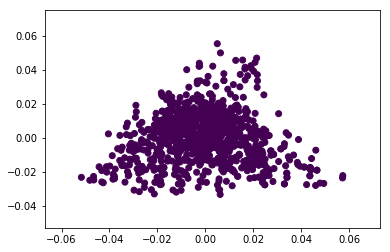

In [55]:
plt.scatter(pca_result[:,0], pca_result[:,1], c=clustering.labels_.astype(float))

In [69]:
clustering = sklearn.cluster.KMeans(n_clusters=10).fit(all_kmers[:, 4:])

In [70]:
clustering.labels_

array([9, 7, 9, ..., 2, 0, 6], dtype=int32)

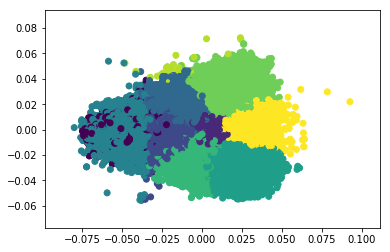

In [72]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(all_kmers[:, 4:])
plt.scatter(pca_result[:,0], pca_result[:,1], c=clustering.labels_.astype(float))

No handles with labels found to put in legend.


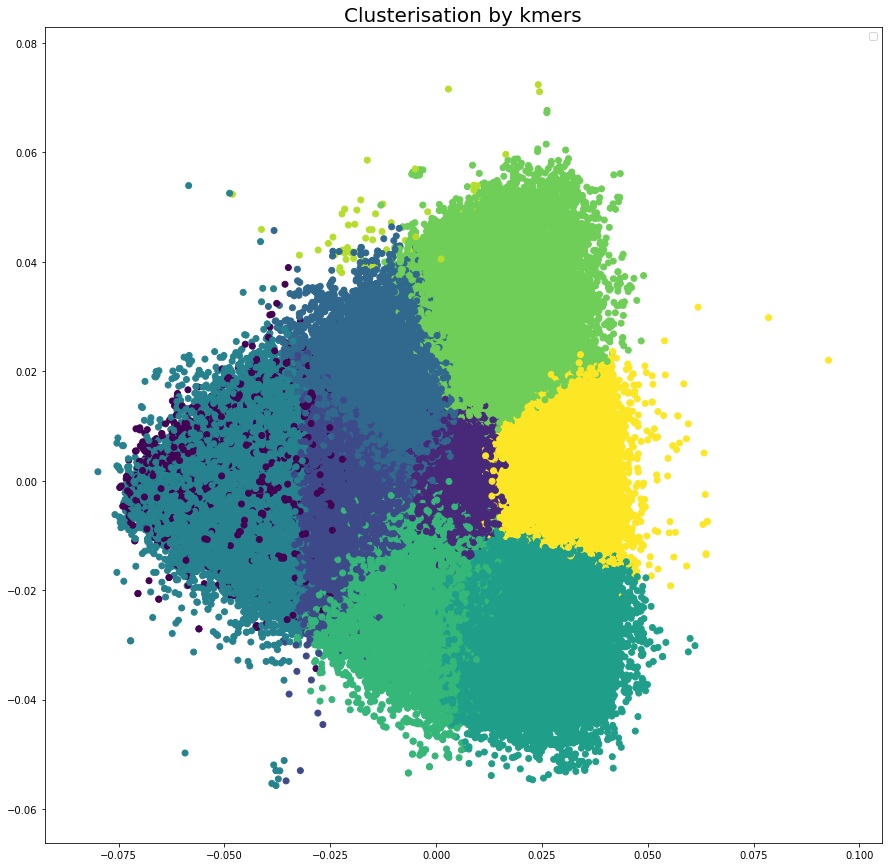

In [76]:
plt.rcParams['axes.titlesize'] = 20
fig = plt.figure(1, figsize=(15, 15))
gs = gridspec.GridSpec(1, 1)
ax0 = fig.add_subplot(gs[0, 0])
spec = ax0.scatter(pca_result[:,0], pca_result[:,1], c=clustering.labels_.astype(float))
ax0.set_ylabel('')
ax0.set_title('Clusterisation by kmers')
ax0.legend()
plt.savefig(f'/home/pitikovegor/CourseWork/genomes/pictures/{cell_type}/{experiment}_{k}_kmeans_10.png')
plt.show()
plt.show()

